In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import models, layers
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score 

from PIL import Image
import glob

/home/sara/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:


#Loops through ImageDataGenerator and grabs true labels and predictions
#and reports metrics with classification_report method
def predict_and_report(gen, model):
    y_true = []
    y_pred = []
    gen.reset()
    for img, label in gen:
        #get true labels for batch and store them
        y_true.extend([int(z[1]) for z in label])
        #Get predictions as probabilities
        batch_pred = model.predict_on_batch(img)
        #turn probabilities to class labels and store
        batch_pred = np.argmax(batch_pred, axis=1)
        y_pred.extend(batch_pred)
        #break loop
        if gen.batch_index == 0:
            break
            
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Area Under the Receiver Operating Characteristic Curve:', roc_auc_score(y_true, y_pred)) #Area under the curve
    print(classification_report(y_true, y_pred))



In [3]:
train_dir = 'data/chest_xray/train'
valid_dir = 'data/chest_xray/validation'
test_dir = 'data/chest_xray/test'

In [4]:
img_width, img_height = 75, 75
batch_size = 16
num_epochs = 5
filter_size = (3, 3)
pool_size = (2, 2)
drop_out_dense = 0.5
drop_out_conv = 0.25
padding = 'same'
#learning_rate = 0.02
#decay = learning_rate / (num_epochs - 1)

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')

Found 5216 images belonging to 2 classes.


In [6]:
validation_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)
validation_generator = validation_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')

Found 16 images belonging to 2 classes.


In [7]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')


Found 624 images belonging to 2 classes.


In [8]:
model = Sequential()

model.add(Conv2D(32, kernel_size=filter_size, activation='relu', input_shape=(img_width, img_height, 1), padding=padding))
model.add(Conv2D(32, kernel_size=filter_size, activation='relu', padding=padding))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(drop_out_conv))

model.add(Conv2D(64, kernel_size=filter_size, activation='relu', padding=padding))
model.add(Conv2D(64, kernel_size=filter_size, activation='relu', padding=padding))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(drop_out_conv))

model.add(Conv2D(96, kernel_size=filter_size, activation='relu', padding=padding))
model.add(Conv2D(96, kernel_size=filter_size, activation='relu', padding=padding))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(drop_out_conv))

model.add(Conv2D(128, kernel_size=filter_size, activation='relu', padding=padding))
model.add(Conv2D(128, kernel_size=filter_size, activation='relu', padding=padding))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(drop_out_conv))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(drop_out_dense))
model.add(Dense(128, activation='relu'))
model.add(Dropout(drop_out_dense))
model.add(layers.Dense(2, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 75, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
__________

In [9]:
SGD = keras.optimizers.SGD(lr = 0.02, decay=75e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

result = model.fit_generator(
            train_generator,
            epochs=num_epochs,
            verbose = 1,
            #class_weight= {0:.40, 1:.60},
            validation_data = validation_generator)

Epoch 1/5
326/326 [==============================] - 140s 429ms/step - loss: 0.5878 - acc: 0.7395 - val_loss: 0.7795 - val_acc: 0.5000
Epoch 2/5
326/326 [==============================] - 135s 414ms/step - loss: 0.5744 - acc: 0.7429 - val_loss: 0.7884 - val_acc: 0.5000
Epoch 3/5
326/326 [==============================] - 136s 416ms/step - loss: 0.5707 - acc: 0.7429 - val_loss: 0.7909 - val_acc: 0.5000
Epoch 4/5
326/326 [==============================] - 142s 436ms/step - loss: 0.5720 - acc: 0.7429 - val_loss: 0.7916 - val_acc: 0.5000
Epoch 5/5
326/326 [==============================] - 139s 427ms/step - loss: 0.5729 - acc: 0.7429 - val_loss: 0.7948 - val_acc: 0.5000


In [10]:
score = model.evaluate_generator(test_generator, steps=50)

print ('Test Score: ', score[0])
print ('Test Accuracy: ',score[1])

Test Score:  0.6721588069200516
Test Accuracy:  0.63375


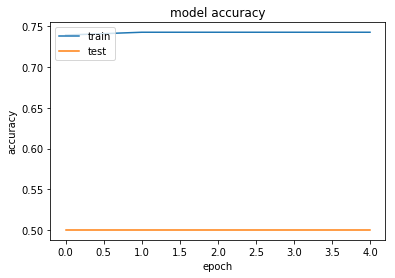

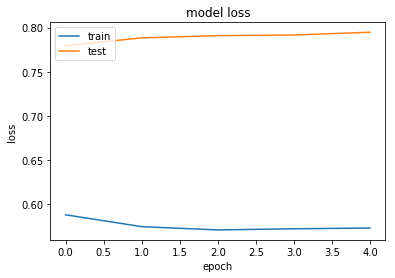

In [11]:
import matplotlib.pyplot as plt

plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

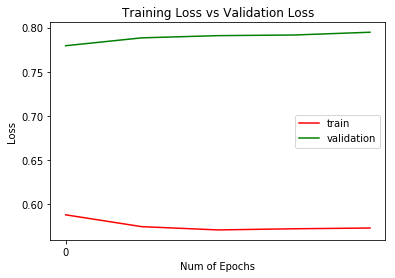

In [12]:
import numpy as np
plt.figure(1)
plt.plot(result.history['loss'],'r')
plt.plot(result.history['val_loss'],'g')
plt.xticks(np.arange(0, num_epochs+1, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])

plt.show()

In [13]:
predict_and_report(train_generator, model)
predict_and_report(validation_generator, model)

Accuracy: 0.7429064417177914
Area Under the Receiver Operating Characteristic Curve: 0.5
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1341
          1       0.74      1.00      0.85      3875

avg / total       0.55      0.74      0.63      5216



/home/sara/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.5
Area Under the Receiver Operating Characteristic Curve: 0.5
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         8
          1       0.50      1.00      0.67         8

avg / total       0.25      0.50      0.33        16



In [14]:
model.layers

In [15]:
filename = validation_generator.filenames
truth = validation_generator.classes
label = validation_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

In [16]:
predicts = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

1/1 [==============================] - 0s 249ms/step
No of errors = 8/16
